In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

sns.set(style="whitegrid", palette="muted", font_scale=1.2)


In [2]:
path = "/Users/elvisrojasmonguia/Documents/Python courses/Proyects/Peruvian National Football Team Results/"

# Cargar el dataset
df = pd.read_csv(path + 'peru_match_results.csv', sep = ',')
df.head(2)

,match_id,rival,rival_confederation,peru_score,rival_score,peru_awarded_score,rival_awarded_score,result,shootout_result,awarded_result,...,tournament_type,official,stadium,city,country,elevation,peru_condition,coach,coach_nationality,date
0,M0001,Uruguay,CONMEBOL,0,4,0,4,L,NaN,L,...,Copa América/Sudamericano,True,Estadio Nacional de Perú,Lima,Peru,154,home,Pedro Olivieri,Uruguay,1927-11-01
1,M0002,Bolivia,CONMEBOL,3,2,3,2,W,NaN,W,...,Copa América/Sudamericano,True,Estadio Nacional de Perú,Lima,Peru,154,home,Pedro Olivieri,Uruguay,1927-11-13


### Exploratory Data Analysis

In [4]:
info_data = pd.DataFrame({
    'Variable': df.columns,
    'Type': [("Numeric" if np.issubdtype(df[col].dtype, np.number) else "Categorical") for col in df.columns],
    'Unique Values': [df[col].nunique() if not np.issubdtype(df[col].dtype, np.number) else 0 for col in df.columns],
    'Null Count': [df[col].isnull().sum() for col in df.columns],
    'Null Percentage': [round(df[col].isnull().sum() / len(df) * 100, 0) for col in df.columns]
}).sort_values(by="Unique Values",ascending=False)

info_data


,Variable,Type,Unique Values,Null Count,Null Percentage
0,match_id,Categorical,695,0,0.0
20,date,Categorical,693,0,0.0
13,stadium,Categorical,168,0,0.0
14,city,Categorical,137,0,0.0
10,tournament_name,Categorical,91,267,38.0
1,rival,Categorical,64,0,0.0
18,coach,Categorical,45,0,0.0
15,country,Categorical,39,0,0.0
11,tournament_type,Categorical,21,267,38.0
19,coach_nationality,Categorical,10,0,0.0


In [5]:
# Select columns where the percentage of missing values ('Null Percentage') is greater than 30%
cols_to_drop = info_data[info_data['Null Percentage'] > 30]['Variable'] 

# Drop the selected columns 
df.drop(cols_to_drop, axis=1, inplace=True)


In [6]:
# Step 1: Convert 'date' column to datetime format for proper date manipulation
df['date'] = pd.to_datetime(df['date'])  # Converts the 'date' column into a pandas datetime object

# Step 2: Calculate the start and end period for each coach's tenure
coach_period = df.groupby('coach').agg(
    start_period=('date', 'min'),  # The earliest date of the coach's tenure (start date)
    end_period=('date', 'max')     # The latest date of the coach's tenure (end date)
).reset_index()

# Step 3: Calculate the tenure duration for each coach in days
coach_period['duration_days_coach'] = (coach_period['end_period'] - coach_period['start_period']).dt.days
# 'duration_days_coach': Represents the total duration of each coach's tenure in days.

# Step 4: Create a period column showing the start and end period in 'MM/YYYY - MM/YYYY' format
coach_period['period'] = coach_period['start_period'].dt.strftime('%Y/%m') + " - " + coach_period['end_period'].dt.strftime('%Y/%m')
# 'period': A formatted string representing the coach's tenure period, e.g., '2020/01 - 2021/06'.

# Step 5: Calculate performance metrics for each coach
performance_metrics = df.groupby('coach').agg(
    matches_played_coach=('match_id', 'count'),  # Total number of matches played under each coach
    wins_coach=('result', lambda x: (x == 'W').sum()),  # Total number of wins
    draws_coach=('result', lambda x: (x == 'D').sum()),  # Total number of draws
    losses_coach=('result', lambda x: (x == 'L').sum()),  # Total number of losses
    goals_scored_coach=('peru_score', 'sum'),  # Total goals scored by Peru under this coach
    goals_conceded_coach=('rival_score', 'sum')  # Total goals conceded by Peru under this coach
).reset_index()

# Step 6: Calculate performance rates and per-match statistics for each coach
columns = {
    'win_rate_coach': 'wins_coach',  # Calculating win rate (wins per match played)
    'draw_rate_coach': 'draws_coach',  # Calculating draw rate (draws per match played)
    'loss_rate_coach': 'losses_coach',  # Calculating loss rate (losses per match played)
    'GSPM_coach': 'goals_scored_coach',  # Goals scored per match played (GSPM)
    'GCPM_coach': 'goals_conceded_coach'  # Goals conceded per match played (GCPM)
}

# Create the new columns by dividing the respective metrics by 'matches_played_coach'
for new_col, old_col in columns.items():
    performance_metrics[new_col] = performance_metrics[old_col] / performance_metrics['matches_played_coach']

# Step 7: Merge performance metrics with the coach period data
performance_metrics = pd.merge(
    performance_metrics, 
    coach_period.drop(columns=["start_period", "end_period"]),  # Drop the unnecessary date columns after merging
    on='coach'
)

# Step 8: Print the number of unique coaches and display descriptive statistics of the performance metrics
print(f"Number of coaches: {performance_metrics['coach'].nunique()}\n")
performance_metrics.describe().round(2).T


Number of coaches: 45



,count,mean,std,min,25%,50%,75%,max
matches_played_coach,45.0,15.44,17.03,1.00,6.00,10.00,17.00,96.00
wins_coach,45.0,5.07,6.83,0.00,1.00,3.00,6.00,38.00
draws_coach,45.0,3.78,4.38,0.00,1.00,2.00,5.00,23.00
losses_coach,45.0,6.60,6.46,0.00,2.00,4.00,8.00,35.00
goals_scored_coach,45.0,18.96,22.17,0.00,4.00,12.00,26.00,117.00
goals_conceded_coach,45.0,21.60,21.22,2.00,9.00,14.00,29.00,110.00
win_rate_coach,45.0,0.28,0.19,0.00,0.14,0.29,0.38,1.00
draw_rate_coach,45.0,0.21,0.13,0.00,0.14,0.23,0.31,0.46
loss_rate_coach,45.0,0.51,0.22,0.00,0.39,0.44,0.57,1.00
GSPM_coach,45.0,1.13,0.71,0.00,0.67,1.00,1.33,3.88


In [7]:
 
# Step 1: Aggregate performance metrics by country (rival team)
performance_by_country = df.groupby('rival').agg(
    matches_played_country=('match_id', 'count'),  # Total number of matches played against each rival
    losses_country=('result', lambda x: (x == 'L').sum()),  # Total number of losses against each rival
    wins_country=('result', lambda x: (x == 'W').sum()),  # Total number of wins against each rival
    goals_scored_country=('peru_score', 'sum'),  # Total number of goals scored by Peru against each rival
    goals_conceded_country=('rival_score', 'sum')  # Total number of goals conceded by Peru against each rival
).reset_index()

# Step 2: Calculate win rate for each rival team
performance_by_country['win_rate_country'] = performance_by_country['wins_country'] / performance_by_country['matches_played_country']
# 'win_rate_country': Win rate for each rival, calculated as the number of wins divided by the total number of matches played.

# Step 3: Sort the performance metrics by win rate in descending order
performance_by_country = performance_by_country.sort_values(by='win_rate_country', ascending=False)
# Sorting the DataFrame by 'win_rate_country' to prioritize rivals with higher win rates.

# Step 4: Print the number of unique rival countries and show summary statistics of the performance metrics
print(f"Number of rivals: {performance_by_country['rival'].nunique()}\n")

performance_by_country.describe().round(2).T

Number of rivals: 64



,count,mean,std,min,25%,50%,75%,max
matches_played_country,64.0,10.86,20.07,1.0,1.00,2.00,5.50,85.0
losses_country,64.0,4.64,10.26,0.0,0.00,1.00,2.00,46.0
wins_country,64.0,3.56,6.25,0.0,0.00,1.00,3.00,24.0
goals_scored_country,64.0,13.33,23.76,0.0,1.00,3.00,10.25,109.0
goals_conceded_country,64.0,15.19,31.34,0.0,0.75,3.00,8.00,134.0
win_rate_country,64.0,0.45,0.38,0.0,0.00,0.43,0.75,1.0


In [8]:
 
## Selecct just Latin American countries
latin_american_countries = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 
    'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 
    'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 
    'Uruguay', 'Venezuela'
]

# Filter the dataset to include only matches against Latin American countries
df_latam = performance_by_country[performance_by_country['rival'].isin(latin_american_countries)].sort_values(by="win_rate_country", ascending=False)

df_latam.head(5)

,rival,matches_played_country,losses_country,wins_country,goals_scored_country,goals_conceded_country,win_rate_country
20,Dominican Republic,1,0,1,4,1,1.000000
42,Nicaragua,1,0,1,2,0,1.000000
27,Guatemala,4,0,3,8,2,0.750000
22,El Salvador,7,2,5,15,6,0.714286
44,Panama,9,2,6,20,7,0.666667


In [9]:
# Just for visualization the performance metrics by last coaches from the year 2000 onwards

# Step 1: Copy the original performance metrics DataFrame to avoid modifying the original data
performance_metrics_2000_onwards = performance_metrics.copy()

# Step 2: Extract the year from the 'period' column and convert it into a float (extract the first 4 characters for the year)
performance_metrics_2000_onwards["date"] = [float(ii[0:4]) for ii in performance_metrics_2000_onwards["period"]]
# 'date' column now holds the year extracted from the 'period' (formatted as 'YYYY/MM - YYYY/MM')

# Step 3: Filter the data for the years 2000 and onwards
performance_metrics_2000_onwards = performance_metrics_2000_onwards[performance_metrics_2000_onwards["date"] >= 2000]

# Step 4: Sort the filtered data by 'date' (to visualize performance over time)
performance_metrics_2000_onwards = performance_metrics_2000_onwards.sort_values(by="date")

 


##### Visualization

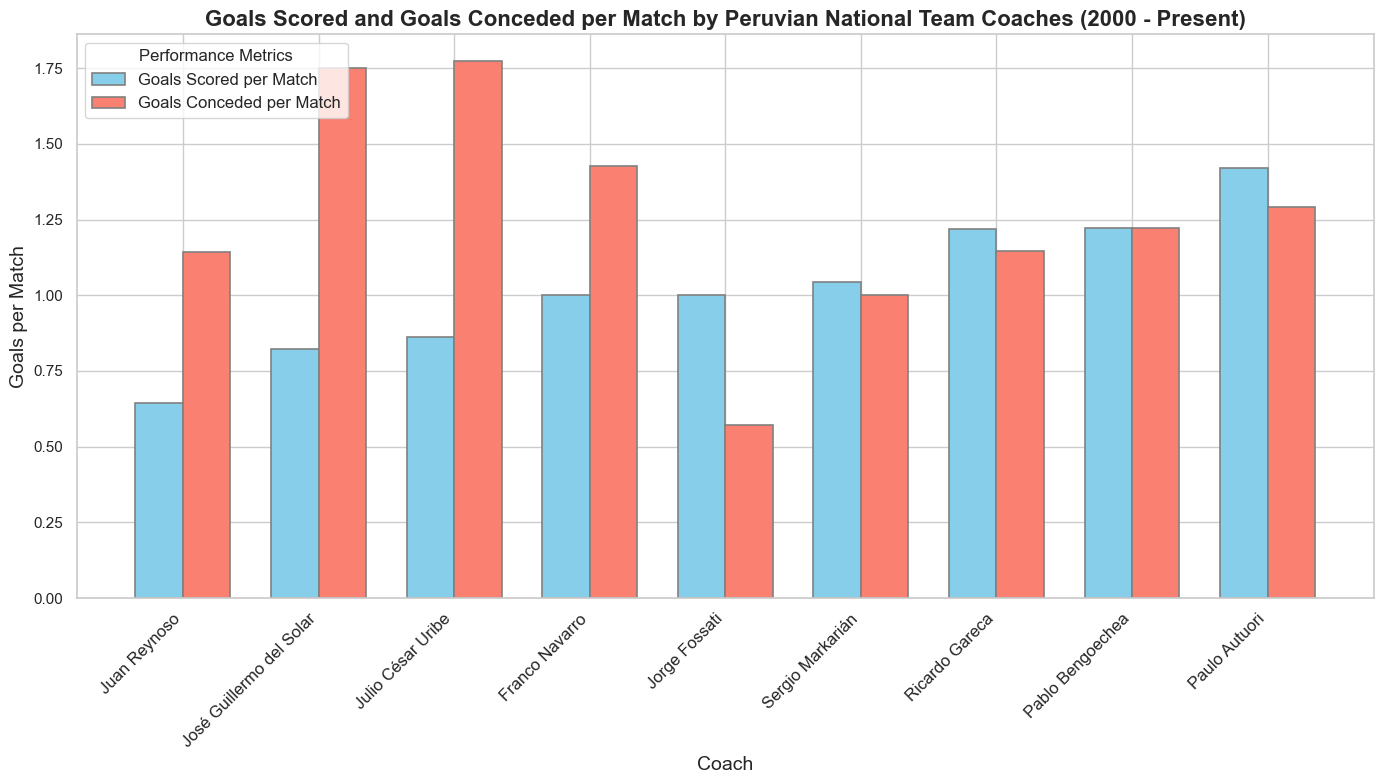

In [11]:
# Sort the data by 'GSPM_coach' (Goals Scored per Match), from lowest to highest
performance_metrics_sorted = performance_metrics_2000_onwards.sort_values(by='GSPM_coach')

# Create the figure with an appropriate size
plt.figure(figsize=(14, 8))

# Set the positions of the bars
x = np.arange(len(performance_metrics_sorted))  # The number of coaches
width = 0.35  # Width of the bars

# Set Seaborn style for more attractive plots
sns.set(style="whitegrid")

# Create bars for Goals Scored per Match (with soft colors)
bars_gspm = plt.bar(x - width/2, performance_metrics_sorted['GSPM_coach'], width, label='Goals Scored per Match', color='skyblue', edgecolor='gray', linewidth=1.2)

# Create bars for Goals Conceded per Match (with soft colors)
bars_gcpm = plt.bar(x + width/2, performance_metrics_sorted['GCPM_coach'], width, label='Goals Conceded per Match', color='salmon', edgecolor='gray', linewidth=1.2)

# Add title and axis labels
plt.title('Goals Scored and Goals Conceded per Match by Peruvian National Team Coaches (2000 - Present)', fontsize=16, fontweight='bold')
plt.xlabel('Coach', fontsize=14)
plt.ylabel('Goals per Match', fontsize=14)

# Add coach names to the x-axis (with rotation)
plt.xticks(x, performance_metrics_sorted['coach'], rotation=45, ha='right', fontsize=12)

# Add legend
plt.legend(title="Performance Metrics", loc='upper left', fontsize=12)

# Adjust spacing and layout to avoid overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


In [12]:
# Find the worst coach in terms of Goals Scored per Match (GSPM)
worst_goals_scored = performance_metrics_2000_onwards.loc[performance_metrics_2000_onwards['GSPM_coach'].idxmin()]

# Find the worst coach in terms of Goals Conceded per Match (GCPM)
worst_goals_conceded = performance_metrics_2000_onwards.loc[performance_metrics_2000_onwards['GCPM_coach'].idxmax()]

# Display the results  
print(f"Worst coach in terms of Goals Scored per Match (GSPM): {worst_goals_scored['coach']} with {worst_goals_scored['GSPM_coach']:.2f} goals per match")
print(f"Worst coach in terms of Goals Conceded per Match (GCPM): {worst_goals_conceded['coach']} with {worst_goals_conceded['GCPM_coach']:.2f} goals conceded per match")

# Create the composite score metric 
performance_metrics_2000_onwards['Composite_Score'] = performance_metrics_2000_onwards['GCPM_coach'] - performance_metrics_2000_onwards['GSPM_coach']

# Find the worst coach 
worst_coach = performance_metrics_2000_onwards.loc[performance_metrics_2000_onwards['Composite_Score'].idxmax()]

# Display the worst performing coach for the composite score
print(f"The worst coach is: {worst_coach['coach']} with a composite score of: {worst_coach['Composite_Score']:.2f}")


Worst coach in terms of Goals Scored per Match (GSPM): Juan Reynoso with 0.64 goals per match
Worst coach in terms of Goals Conceded per Match (GCPM): Julio César Uribe with 1.77 goals conceded per match
The worst coach is: José Guillermo del Solar with a composite score of: 0.93


#### Completing database

In [14]:
## merge with nean data by rival: 
final_df = df.merge(performance_by_country, on='rival').merge(performance_metrics, on='coach')

In [15]:
similarity_percentage = ( (df['result'] == df['awarded_result']).sum() / len(df)) * 100
print(f"Similarity between 'result' and 'awarded_result': {similarity_percentage:.2f}%")

Similarity between 'result' and 'awarded_result': 98.85%


In [16]:
final_df.drop(columns=["period", "date", "peru_awarded_score", "rival_awarded_score", "awarded_result", "match_id"], 
              axis=1, inplace=True, errors='coerce')


In [17]:
final_df.info(verbose=2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rival                   695 non-null    object 
 1   rival_confederation     695 non-null    object 
 2   peru_score              695 non-null    int64  
 3   rival_score             695 non-null    int64  
 4   result                  695 non-null    object 
 5   official                695 non-null    bool   
 6   stadium                 695 non-null    object 
 7   city                    695 non-null    object 
 8   country                 695 non-null    object 
 9   elevation               695 non-null    int64  
 10  peru_condition          695 non-null    object 
 11  coach                   695 non-null    object 
 12  coach_nationality       695 non-null    object 
 13  matches_played_country  695 non-null    int64  
 14  losses_country          695 non-null    in

#### Visualization

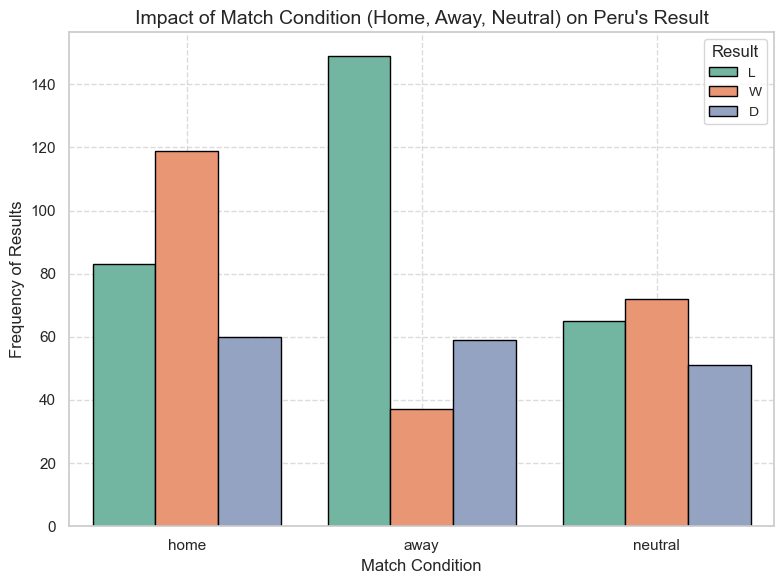

In [19]:
# Set the style for better readability
sns.set(style="whitegrid")

# Create the countplot for home, away, and neutral conditions
plt.figure(figsize=(8,6))  # Adjust the figure size
sns.countplot(data=final_df, x="peru_condition", hue="result", order=["home", "away", "neutral"], 
              palette="Set2", edgecolor='black')

# Set the title with more descriptive text
plt.title("Impact of Match Condition (Home, Away, Neutral) on Peru's Result", fontsize=14)

# Improve labels for readability
plt.xlabel("Match Condition", fontsize=12)
plt.ylabel("Frequency of Results", fontsize=12)

# Add a legend and adjust its position
plt.legend(title="Result", loc="upper right", fontsize=10, title_fontsize=12)

# Add gridlines for better reference
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot with better spacing and avoid clutter
plt.tight_layout()
plt.show()

Playing at home increase the chances of winning, while playing away reduces them. Playing on a neutral court does not determine the result.

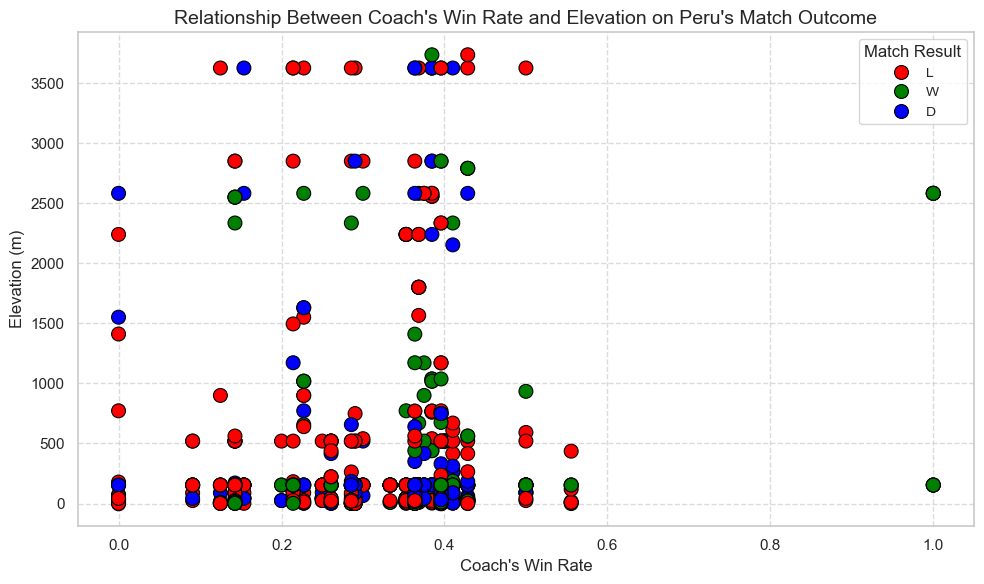

In [21]:
# Create the scatter plot with a refined color palette and axis labels
plt.figure(figsize=(10, 6))  # Adjust figure size for clarity
sns.scatterplot(data=final_df, x="win_rate_coach", y="elevation", hue="result", 
                palette={"W": "green", "D": "blue", "L": "red"}, s=100, edgecolor='black')

# Set a more informative title
plt.title("Relationship Between Coach's Win Rate and Elevation on Peru's Match Outcome", fontsize=14)

# Set labels with appropriate font sizes
plt.xlabel("Coach's Win Rate", fontsize=12)
plt.ylabel("Elevation (m)", fontsize=12)

# Add a legend and adjust its position
plt.legend(title="Match Result", loc="upper right", fontsize=10, title_fontsize=12)

# Add gridlines for better visualization of data points
plt.grid(True, linestyle='--', alpha=0.7)

# Make sure the plot fits nicely
plt.tight_layout()

# Show the plot
plt.show()

As elevation increases, the number of losses also tends to rise. However, the coach's win rate remains at an intermediate level. Additionally, it appears that in the elevation range between 500 and 3000 meters, Peru's performance improves, coinciding with a coach's win rate between 0.2 and 0.5.

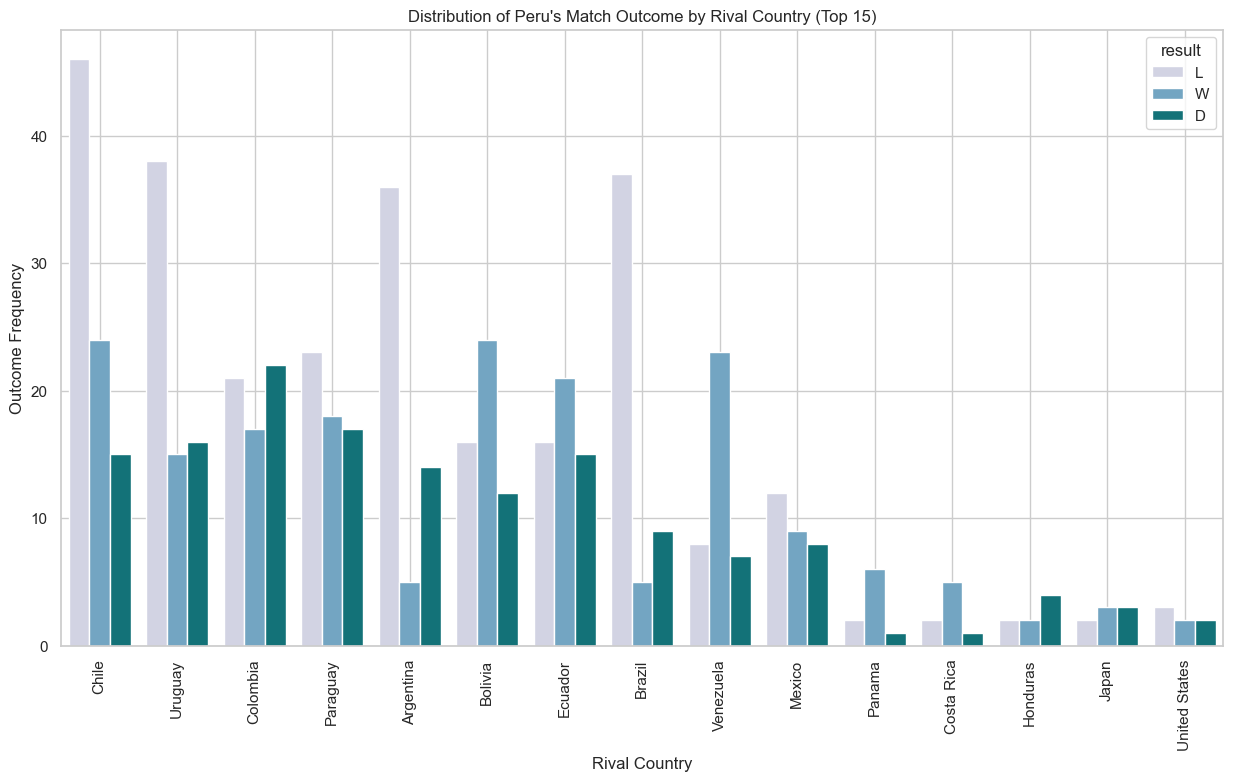

In [22]:
# Get the top 15 countries based on the frequency of matches
top_15_countries = final_df['rival'].value_counts().head(15).index

# Plot countplot for the top 15 countries only
plt.figure(figsize=(15,8))
sns.countplot(data=final_df, x='rival', hue='result', palette="PuBuGn", order=top_15_countries)
plt.title('Distribution of Peru\'s Match Outcome by Rival Country (Top 15)')
plt.xlabel('Rival Country')
plt.ylabel('Outcome Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


Chile is the country against which the most matches have been played, and it is also the country where Peru has suffered the most losses. Bolivia and Ecuador occupy the sixth and seventh positions, respectively, with more victories than defeats. Brazil and Argentina are the countries where Peru has experienced more losses than wins.

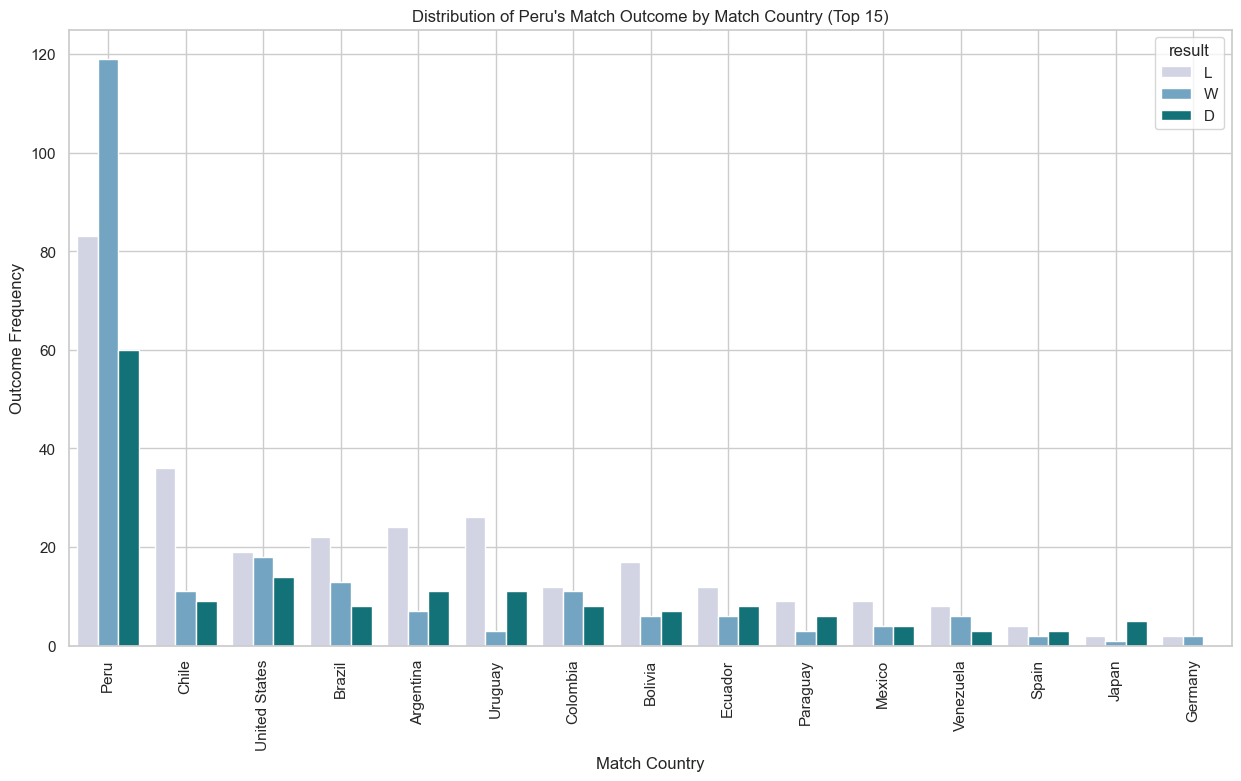

In [23]:
# Get the top 15 countries based on the frequency of matches
top_15_countries = final_df['country'].value_counts().head(15).index

# Plot countplot for the top 15 countries only
plt.figure(figsize=(15,8))
sns.countplot(data=final_df, x='country', hue='result', palette="PuBuGn", order=top_15_countries)
plt.title('Distribution of Peru\'s Match Outcome by Match Country (Top 15)')
plt.xlabel('Match Country')
plt.ylabel('Outcome Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


Peru is the country where the most matches have been played, followed by Chile and the USA. Among these top three countries in the ranking, Peru has achieved the highest number of victories.

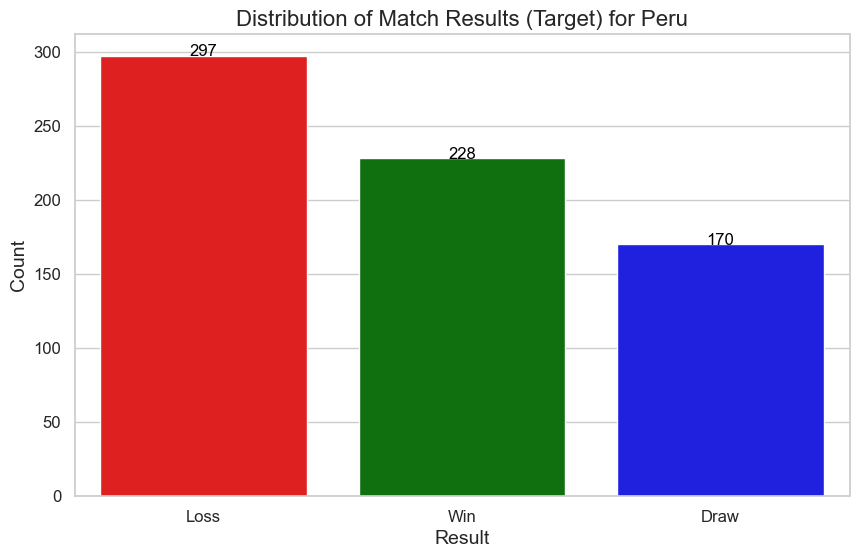

In [24]:
 
# Map the abbreviated results to full words
label_feature_var = {'W': 'Win', 'D': 'Draw', 'L': 'Loss'}
final_df['result_full'] = final_df['result'].map(label_feature_var)

# Count of each result category
results_count = final_df["result_full"].value_counts().reset_index()
results_count.columns = ["result_full", "count"]

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=results_count, x="result_full", y="count", hue="result_full", palette={"Win": "green", "Draw": "blue", "Loss": "red"}, dodge=False, legend=False)

# Add labels to the bars
for index, row in results_count.iterrows():
    barplot.text(row.name, row['count'], row['count'], color='black', ha="center", fontsize=12)

plt.title("Distribution of Match Results (Target) for Peru", fontsize=16)
plt.xlabel("Result", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Future Engineering

In [26]:
final_df['result'].value_counts().index

Index(['L', 'W', 'D'], dtype='object', name='result')

In [27]:
# Encode results as numerical values
label_mapping = {"L": 0, "D": 1, "W": 2}

# Apply the mapping
final_df['result_encoded'] = final_df['result'].map(label_mapping)


In [28]:
#remove unnecesary variables
final_df.drop(['result',"result_full", 'peru_score', 'rival_score'], axis=1, inplace=True)


In [29]:
# Select categorical columns
categorical_cols = final_df.select_dtypes(include=['object', 'boolean'])
categorical_cols.nunique().index.tolist()

['rival',
 'rival_confederation',
 'official',
 'stadium',
 'city',
 'country',
 'peru_condition',
 'coach',
 'coach_nationality']

In [30]:
# Filter columns with more than 3 unique categories and get their names
filtered_col_names = categorical_cols.nunique()[categorical_cols.nunique() > 3].index.tolist()
filtered_col_names

['rival',
 'rival_confederation',
 'stadium',
 'city',
 'country',
 'coach',
 'coach_nationality']

In [31]:
# more than 3 categories
for col in filtered_col_names:
    freq_encoding = final_df[col].value_counts() / len(final_df)
    final_df[col] = final_df[col].map(freq_encoding)

## 3 categories 
final_df = pd.get_dummies(final_df, columns=['peru_condition'], drop_first=False )
 

## 2 categories : Convert boolean columns to numeric (0 and 1) 
le = LabelEncoder()
final_df['official'] = le.fit_transform(final_df['official'])

## booleans
final_df = final_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)


/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_29820/2240956242.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df = final_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [32]:
#find categorical variables
final_df.select_dtypes(include=['object', 'boolean']).nunique().index.tolist()

[]

In [33]:
def remove_highly_correlated_features(df, threshold=0.99):
    corr_matrix = df.corr().abs()
    upper   = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, to_drop

# Apply the function to remove highly correlated features
final_df_reduced, dropped_features = remove_highly_correlated_features(final_df)
print(f"Features dropped due to high correlation:\n {dropped_features}")
print(f"Total Features dropped due to high correlation:\n {len(dropped_features)}")
  

Features dropped due to high correlation:
 ['matches_played_country', 'matches_played_coach', 'peru_condition_home']
Total Features dropped due to high correlation:
 3


### Models

#### Machine learning

In [36]:
# Define features and target
X = final_df_reduced.drop(columns=['result_encoded'])
y = final_df_reduced['result_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler   = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test   = scaler.transform(X_test)


In [37]:
 
def evaluate_ML_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'Test Accuracy': accuracy_score(y_test, y_pred_test),
        'Train Precision': precision_score(y_train, y_pred_train, average='macro'),
        'Test Precision': precision_score(y_test, y_pred_test, average='macro'),
        'Train Recall': recall_score(y_train, y_pred_train, average='macro'),
        'Test Recall': recall_score(y_test, y_pred_test, average='macro'),
        'Train F1-Score': f1_score(y_train, y_pred_train, average='macro'),
        'Test F1-Score': f1_score(y_test, y_pred_test, average='macro')
    }
    print(f"{model_name}: done \n")
 
    return metrics

# Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
}

# Support Vector Machine
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'poly', 'rbf'],
}

# Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [None, 0.8, 0.9]  # To prevent overfitting
}

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 1, 2],  # To control overfitting
    'reg_alpha': [0, 0.01, 0.1], # L1 regularization
}

def perform_hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Find best models and parameters
best_estimators = {}
best_params     = {}

best_estimators['Logistic Regression'], best_params['Logistic Regression'] = perform_hyperparameter_tuning(
    LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42), param_grid_lr, X_train, y_train
)
best_estimators['SVM'], best_params['SVM'] = perform_hyperparameter_tuning(
    SVC(probability=True, random_state=42), param_grid_svm, X_train, y_train
)
best_estimators['Random Forest'], best_params['Random Forest'] = perform_hyperparameter_tuning(
    RandomForestClassifier(random_state=42), param_grid_rf, X_train, y_train
)
best_estimators['XGBoost'], best_params['XGBoost'] = perform_hyperparameter_tuning(
    xgb.XGBClassifier(random_state=42), param_grid_xgb, X_train, y_train
)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...............................C=0.001, solver=saga; total time=   0.0s
[CV] END .................................C=0.01, solver=sag; total time=   0.0s
[CV] END ................................C=0.01, solver=saga; total time=   0.0s
[CV] END ..................................C=0.1, solver=sag; total time=   0.0s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.0s
[CV] END ...................................C=1, solver=saga; total time=   0.0s
[CV] END ................................C=100, solver=lbfgs; total time=   0.0s
[CV] END ..................................C=100, solver=sag; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; t

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1215 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
931 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits

[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.7s
[CV] END max_depth=20, max_features=sqrt, max_samples=None, min_samples_leaf=1, min_samples_split=10

In [38]:
# List to store the results
results = []

# Evaluate ML models
for name, model in best_estimators.items():
    metrics = evaluate_ML_model(model, X_train, y_train, X_test, y_test, name)
    results.append(metrics)

# Print the best parameters for each model
for name, params in best_params.items():
    print(f"Best parameters for {name}: {params}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression: done 

SVM: done 

Random Forest: done 

XGBoost: done 

Best parameters for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}
Best parameters for SVM: {'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}
Best parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.9}


In [39]:
# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)


 #### Neural Networks

In [41]:
def evaluate_DL_model(model, name_model, X_train, y_train, X_test, y_test):
    # Evaluate the model on train set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_predictions          = model.predict(X_train).argmax(axis=1)
    train_true_labels          = y_train.argmax(axis=1)
    train_precision            = precision_score(train_true_labels, train_predictions, average='macro')
    train_recall               = recall_score(train_true_labels, train_predictions, average='macro')
    train_f1                   = f1_score(train_true_labels, train_predictions, average='macro')
    
    # Evaluate the model on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_predictions         = model.predict(X_test).argmax(axis=1)
    test_true_labels         = y_test.argmax(axis=1)
    test_precision           = precision_score(test_true_labels, test_predictions, average='macro')
    test_recall              = recall_score(test_true_labels, test_predictions, average='macro')
    test_f1                  = f1_score(test_true_labels, test_predictions, average='macro')

    # Create a list of metrics
    metrics_list = [
         name_model, train_accuracy, test_accuracy,
        train_precision, test_precision,
        train_recall, test_recall,
        train_f1, test_f1
    ]
    
    return pd.DataFrame([metrics_list],
                        columns=['Model', 
                                 'Train Accuracy', 'Test Accuracy', 
                                 'Train Precision', 'Test Precision', 
                                 'Train Recall', 'Test Recall', 
                                 'Train F1-Score', 'Test F1-Score'])


In [42]:
# define params 
epochs_num = 100
batch_size_num = 32

##### Multilayer Perceptron 

In [44]:
# One-Hot Encoding of the target variable
y_train_mlp = to_categorical(y_train, num_classes=3)
y_test_mlp = to_categorical(y_test, num_classes=3)

# Create the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Three categories: 0, 1, 2

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_mlp, epochs=epochs_num, batch_size=batch_size_num, validation_data=(X_test, y_test_mlp), verbose=0)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# Get performance metrics form Multilayer Perceptron (MLP) model 
metrics_mlp = evaluate_DL_model(model, "MLP", X_train, y_train_mlp, X_test, y_test_mlp)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##### Recurrent Neural Networks

In [47]:
 
# Defining your target variable and feature variables
target_variable   = 'result_encoded'
feature_variables = [col for col in final_df_reduced.columns if col != target_variable]

# Creating time sequences for RNN
def create_sequences(features, target, sequence_length):
    sequences = []
    labels    = []
    for i in range(len(features) - sequence_length):
        
        sequence = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
        
    return np.array(sequences), np.array(labels)

sequence_length   = 10
features          = final_df_reduced[feature_variables].values
target            = final_df_reduced[target_variable].values
sequences, labels = create_sequences(features, target, sequence_length)

# Split data into training and test sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler        = StandardScaler()
num_features  = X_train_nn.shape[2]

for i in range(num_features):
    X_train_nn[:, :, i] = scaler.fit_transform(X_train_nn[:, :, i])
    X_test_nn[:, :, i]  = scaler.transform(X_test_nn[:, :, i])

# One-hot encode the target variable 
y_train_one_hot = to_categorical(y_train_nn, num_classes=3)
y_test_one_hot  = to_categorical(y_test_nn, num_classes=3)
 


In [48]:
# Create the LSTM model with regularization
model_lstm = Sequential()
model_lstm.add(Input(shape=(X_train_nn.shape[1], X_train_nn.shape[2])))
model_lstm.add(LSTM(100, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(50, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3, activation='softmax'))  # Three output neurons with softmax activation for multi-class output classification (0,1,2)

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model_lstm.fit(X_train_nn, y_train_one_hot, epochs=epochs_num, batch_size=batch_size_num, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3768 - loss: 2.8358 - val_accuracy: 0.4455 - val_loss: 2.5156
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4310 - loss: 2.4334 - val_accuracy: 0.4909 - val_loss: 2.1827
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4089 - loss: 2.1643 - val_accuracy: 0.5000 - val_loss: 1.9238
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4362 - loss: 1.8872 - val_accuracy: 0.5000 - val_loss: 1.7281
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4567 - loss: 1.6863 - val_accuracy: 0.5091 - val_loss: 1.5900
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4712 - loss: 1.5667 - val_accuracy: 0.4636 - val_loss: 1.4789
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4647 - loss: 1.4756 - val_accuracy: 0.4636 - val_loss: 1.3969
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4835 - loss: 1.3700 - val_accuracy: 0.4455 - 

In [49]:
# Evaluate the LSTM model
metrics_lstm = evaluate_DL_model(model_lstm, "LSTM" , X_train_nn, y_train_one_hot, X_test_nn, y_test_one_hot)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [50]:

# Defining the GRU model with regularization
model_gru = Sequential()
model_gru.add(Input(shape=(X_train_nn.shape[1], X_train_nn.shape[2])))
model_gru.add(GRU(100, return_sequences=True, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(3, activation='softmax'))  # Three categories: 0, 1, 2

# Compile the model
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model_gru.fit(X_train_nn, y_train_one_hot, epochs=epochs_num, batch_size=batch_size_num, validation_split=0.2, callbacks=[early_stopping], verbose=1)

 

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3480 - loss: 2.7764 - val_accuracy: 0.4455 - val_loss: 2.4556
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3718 - loss: 2.4836 - val_accuracy: 0.4909 - val_loss: 2.1880
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4292 - loss: 2.2000 - val_accuracy: 0.4818 - val_loss: 1.9958
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4403 - loss: 2.0146 - val_accuracy: 0.4636 - val_loss: 1.8302
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4561 - loss: 1.8185 - val_accuracy: 0.4636 - val_loss: 1.7061
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5039 - loss: 1.6950 - val_accuracy: 0.4636 - val_loss: 1.6107
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4758 - loss: 1.6480 - val_accuracy: 0.4636 - val_loss: 1.5339
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4233 - loss: 1.5855 - val_accuracy: 0.4727 -

In [51]:
# Evaluate the GRU model
metrics_gru = evaluate_DL_model(model_gru, "GRU",X_train_nn, y_train_one_hot, X_test_nn, y_test_one_hot)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [52]:
 
# Defining the Conv1D model with regularization
model_conv1d = Sequential()
model_conv1d.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_nn.shape[1], X_train_nn.shape[2]), kernel_regularizer=l2(0.01)))
model_conv1d.add(MaxPooling1D(pool_size=2))
model_conv1d.add(Flatten())
model_conv1d.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.01)))  # Three categories: 0, 1, 2

# Compile the model
model_conv1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model_conv1d.fit(X_train_nn, y_train_one_hot, epochs=epochs_num, batch_size=batch_size_num, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3332 - loss: 1.6750 - val_accuracy: 0.4364 - val_loss: 1.5204
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4439 - loss: 1.5077 - val_accuracy: 0.4091 - val_loss: 1.5000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4844 - loss: 1.4101 - val_accuracy: 0.4364 - val_loss: 1.4887
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5457 - loss: 1.3390 - val_accuracy: 0.4182 - val_loss: 1.4877
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5814 - loss: 1.2859 - val_accuracy: 0.4182 - val_loss: 1.4708
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6207 - loss: 1.2461 - val_accuracy: 0.4182 - val_loss: 1.4699
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6754 - loss: 1.2104 - val_accuracy: 0.4364 - val_loss: 1.4669
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6629 - loss: 1.1738 - val_accuracy: 0.4000 - val_loss: 1.4

In [53]:
# Evaluate the Conv1D model
metrics_conv1d = evaluate_DL_model(model_conv1d, "Conv1D", X_train_nn, y_train_one_hot, X_test_nn, y_test_one_hot)
 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### Performance  measures

In [55]:
# Concatenating the new metrics DataFrames with the original DataFrame
results_ALL_df = pd.concat([results_df, metrics_mlp, metrics_lstm, metrics_gru, metrics_conv1d], ignore_index=True).round(3)
results_ALL_df

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-Score,Test F1-Score
0,Logistic Regression,0.615,0.583,0.581,0.561,0.564,0.553,0.556,0.533
1,SVM,0.624,0.554,0.588,0.529,0.574,0.529,0.566,0.515
2,Random Forest,0.766,0.532,0.790,0.478,0.729,0.487,0.739,0.449
3,XGBoost,0.768,0.518,0.773,0.498,0.734,0.483,0.740,0.461
4,MLP,0.921,0.453,0.919,0.404,0.911,0.426,0.915,0.412
5,LSTM,0.513,0.438,0.442,0.451,0.444,0.401,0.397,0.345
6,GRU,0.511,0.394,0.505,0.350,0.464,0.365,0.457,0.329
7,Conv1D,0.637,0.372,0.659,0.325,0.607,0.345,0.616,0.328


In [56]:
# Identifying the model with the highest Test F1-Score
best_model_f1 = results_ALL_df.loc[results_ALL_df['Test F1-Score'].idxmax()].iloc[0]
print(f"The best model based on F1-score is: {best_model_f1}")


The best model based on F1-score is: Logistic Regression


#### Evaluation of Top-Performing Model

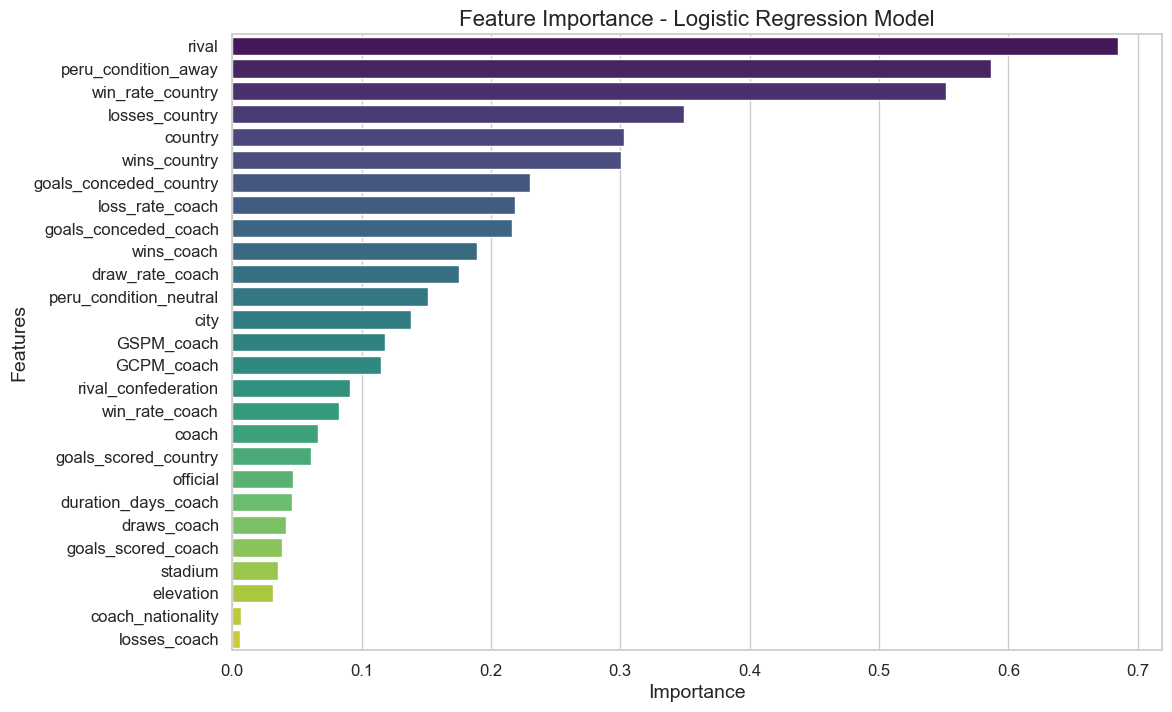

In [59]:

#   'best_logreg' is the best logistic regression model from hyperparameter tuning
coefficients = best_estimators[best_model_f1].coef_[0]
feature_names = final_df_reduced.drop(columns=['result_encoded']).columns

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df['Importance'] = importance_df['Coefficient'].abs()  # Use absolute values for importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances (coefficients)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', dodge=False, legend=False)
plt.title('Feature Importance - Logistic Regression Model', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [72]:
 
# Predictions for the test set
y_pred_test = best_estimators[best_model_f1].predict(X_test)
 # Get the probability estimates for each class
y_prob_test = best_estimators[best_model_f1].predict_proba(X_test)


<Figure size 1000x800 with 0 Axes>

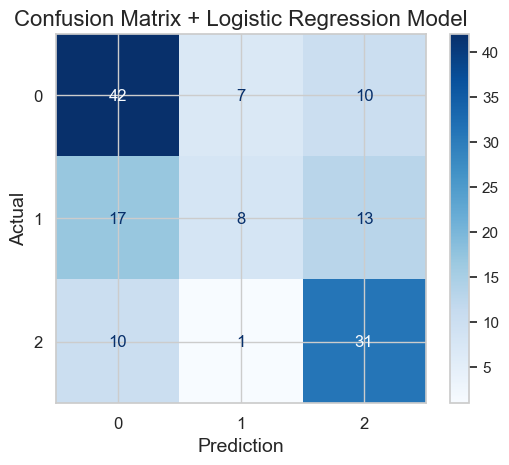

In [78]:
# Create the confusion matrix
cm    = confusion_matrix(y_test, y_pred_test,       labels= best_estimators[best_model_f1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimators[best_model_f1].classes_)


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix + {best_model_f1} Model', fontsize=16)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [92]:
label_mapping_inv = {0:'L', 1:"D", 2:"W"}; 

# Create a DataFrame to display the probabilities
prob_df = pd.DataFrame(y_prob_test, columns=best_estimators[best_model_f1].classes_)
# Rename the columns to full names for clarity
prob_df.rename(label_mapping_inv, axis=1, inplace=True, errors='coerce')

# Add the actual results and predicted results to the DataFrame for comparison with string labels
prob_df['Actual Result']  = y_test.reset_index(drop=True).map(label_mapping_inv)
prob_df['Predict Result'] = pd.Series(y_pred_test).map(label_mapping_inv)

# Display where the actual result does not match the predicted result
prob_df[prob_df["Actual Result"] != prob_df["Predict Result"]].round(2).head(10)


,L,D,W,Actual Result,Predict Result
3,0.35,0.57,0.08,L,D
4,0.24,0.25,0.51,D,W
5,0.56,0.24,0.19,D,L
11,0.76,0.23,0.01,D,L
12,0.40,0.08,0.53,L,W
13,0.62,0.13,0.25,D,L
16,0.29,0.19,0.52,D,W
18,0.46,0.29,0.24,W,L
19,0.30,0.29,0.40,L,W
22,0.40,0.36,0.24,D,L


In many cases where the model makes an incorrect prediction, the second-highest probability often corresponds to the actual result. This observation suggests that a future task could involve handling such prediction errors by exploring strategies to better differentiate between classes when the model shows uncertainty, particularly when the top two probabilities are close.